# Explicit WFA Inversion (Legacy)

This notebook demonstrates the usage of the refactored `neural_wfa` package for EXPLICIT (pixel-by-pixel) inversion.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os, sys
from tqdm import tqdm, trange
from einops import rearrange

sys.path.append("../")
from legacy import utils
from legacy import neural_fields, bfield
from legacy import explicit
from legacy.plot_params import set_params
set_params()

%load_ext autoreload
%autoreload 2

## Spatial regularization & optimization

In [5]:
# Readind the data:
import astropy.io.fits as fits

datadir = "plage_sst/"
img = np.ascontiguousarray(
    fits.open(datadir + "CRISP_5173_plage_dat.fits", "readonly")[0].data,
    dtype="float32",
)
xl = np.ascontiguousarray(
    fits.open(datadir + "CRISP_5173_plage_wav.fits", "readonly")[0].data,
    dtype="float32",
)
ny, nx, nStokes, nWav = img.shape
print("Data shape:", img.shape)


Data shape: (200, 178, 4, 13)


In [6]:
# Model
niter = 200
mask_index = [5, 6, 7]  # Points to use for the estimation
mymodel = bfield.WFA_model3D(img,xl,mask=mask_index, spectral_line=5173)

# Spatial regularization:
reguV=1e-4
reguQU=1e-2

# Original analytical WFA estimate (without regularization):
B0, B1, B2 = mymodel.initial_guess(inner=False, split=True)



Data: torch.Size([200, 178, 4, 13]) should be in the format [(nt) ny nx ns nw]
Wav: (13,) should be in Angstroms relative to the center of the line
mask: [5, 6, 7] are the indices to use during the optimization


In [7]:
# Initial guess
out = explicit.prepare_initial_guess(mymodel)
optimizer = torch.optim.Adam([out], lr=1e-2)


# Optimizer & optimization
outplot, out = explicit.optimization(optimizer=optimizer,niterations=niter, parameters=out,model=mymodel, reguV=reguV, reguQU=reguQU, weights=[10,10,10], normgrad=True)


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:11<00:00, 17.80it/s, total=0.262, chi2=0.258, spatial=0.00369, temporal=0]


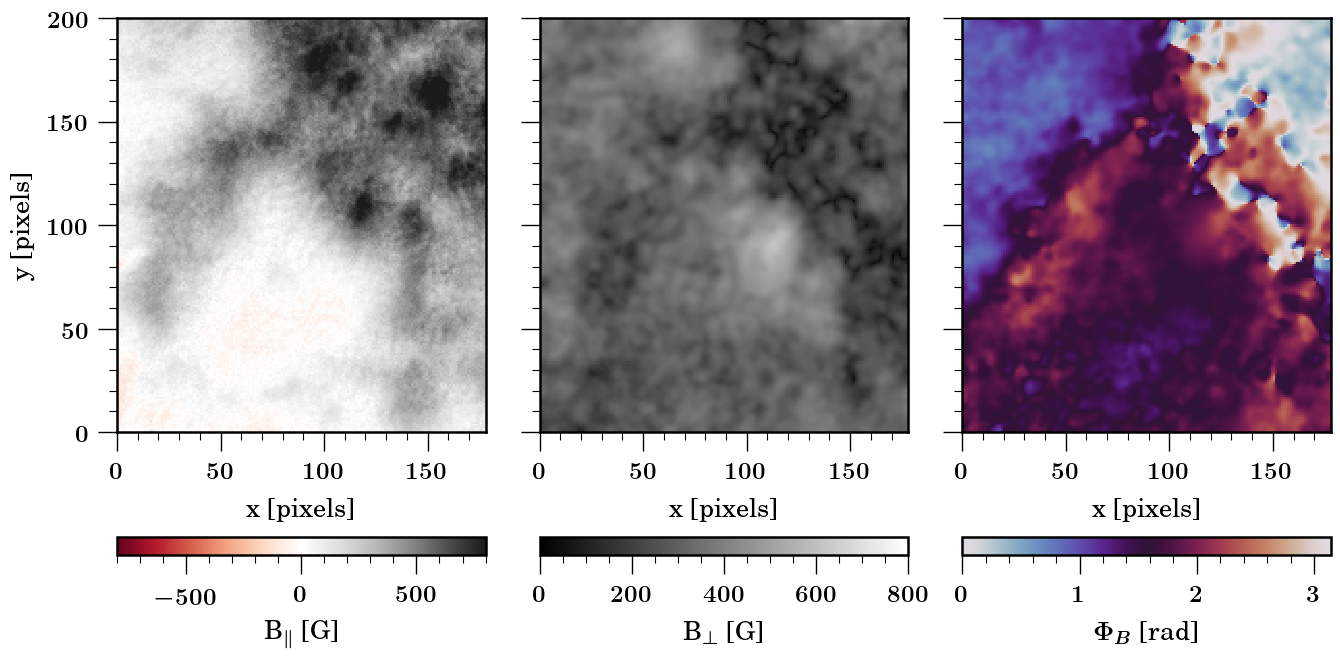

In [8]:
# Plots
Blos, Bhor, Bazi = outplot[:,:,0,0], outplot[:,:,0,1], outplot[:,:,0,2]
plt.close("all");
extent = np.float64((0,nx,0,ny))
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(9*1.5,4.5*1.5))
im0 = ax[0].imshow(Blos, vmax=800, vmin=-800, cmap='RdGy',      interpolation='nearest', extent=extent)
im1 = ax[1].imshow(Bhor, vmin=0, vmax=800,   cmap='gist_gray', interpolation='nearest', extent=extent)
im2 = ax[2].imshow(Bazi, vmax=np.pi, vmin=0,    cmap='twilight',      interpolation='nearest', extent=extent)

names = [r'B$_\parallel$', r'B$_\bot$', r'$\Phi_B$']
f.colorbar(im0, ax=ax[0], orientation='horizontal', label=names[0]+' [G]', pad=0.17)
f.colorbar(im1, ax=ax[1], orientation='horizontal', label=names[1]+' [G]', pad=0.17)
f.colorbar(im2, ax=ax[2], orientation='horizontal', label=names[2]+' [rad]', pad=0.17)

for ii in range(1,3):
    ax[ii].set_yticklabels([])
for ii in range(3):
    ax[ii].set_xlabel('x [pixels]')
    ax[ii].minorticks_on()
    ax[ii].locator_params(axis='x', nbins=5)
    ax[ii].locator_params(axis='y', nbins=5)
ax[0].set_ylabel('y [pixels]')
f.set_tight_layout(True)

for cbar in f.get_axes():
    cbar.minorticks_on() # Minorticks in the colorbar:


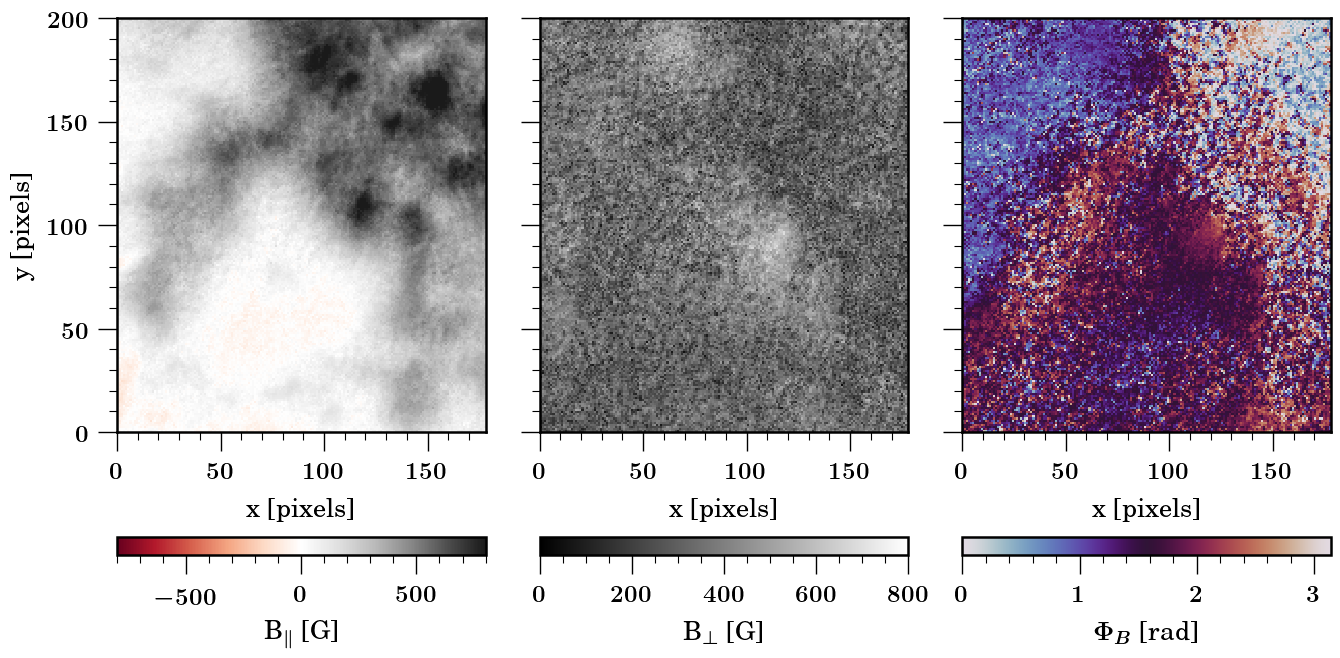

In [6]:
# Plots
plt.close("all");
extent = np.float64((0,nx,0,ny))
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(9*1.5,4.5*1.5))
im0 = ax[0].imshow(B0.reshape(ny,nx), vmax=800, vmin=-800, cmap='RdGy',      interpolation='nearest', extent=extent)
im1 = ax[1].imshow(B1.reshape(ny,nx), vmin=0, vmax=800,   cmap='gist_gray', interpolation='nearest', extent=extent)
im2 = ax[2].imshow(B2.reshape(ny,nx), vmax=np.pi, vmin=0,    cmap='twilight',      interpolation='nearest', extent=extent)

names = [r'B$_\parallel$', r'B$_\bot$', r'$\Phi_B$']
f.colorbar(im0, ax=ax[0], orientation='horizontal', label=names[0]+' [G]', pad=0.17)
f.colorbar(im1, ax=ax[1], orientation='horizontal', label=names[1]+' [G]', pad=0.17)
f.colorbar(im2, ax=ax[2], orientation='horizontal', label=names[2]+' [rad]', pad=0.17)

for ii in range(1,3):
    ax[ii].set_yticklabels([])
for ii in range(3):
    ax[ii].set_xlabel('x [pixels]')
    ax[ii].minorticks_on()
    ax[ii].locator_params(axis='x', nbins=5)
    ax[ii].locator_params(axis='y', nbins=5)
ax[0].set_ylabel('y [pixels]')
f.set_tight_layout(True)


for cbar in f.get_axes():
    cbar.minorticks_on() # Minorticks in the colorbar:


Computing uncertainties using ANALYTICAL method...


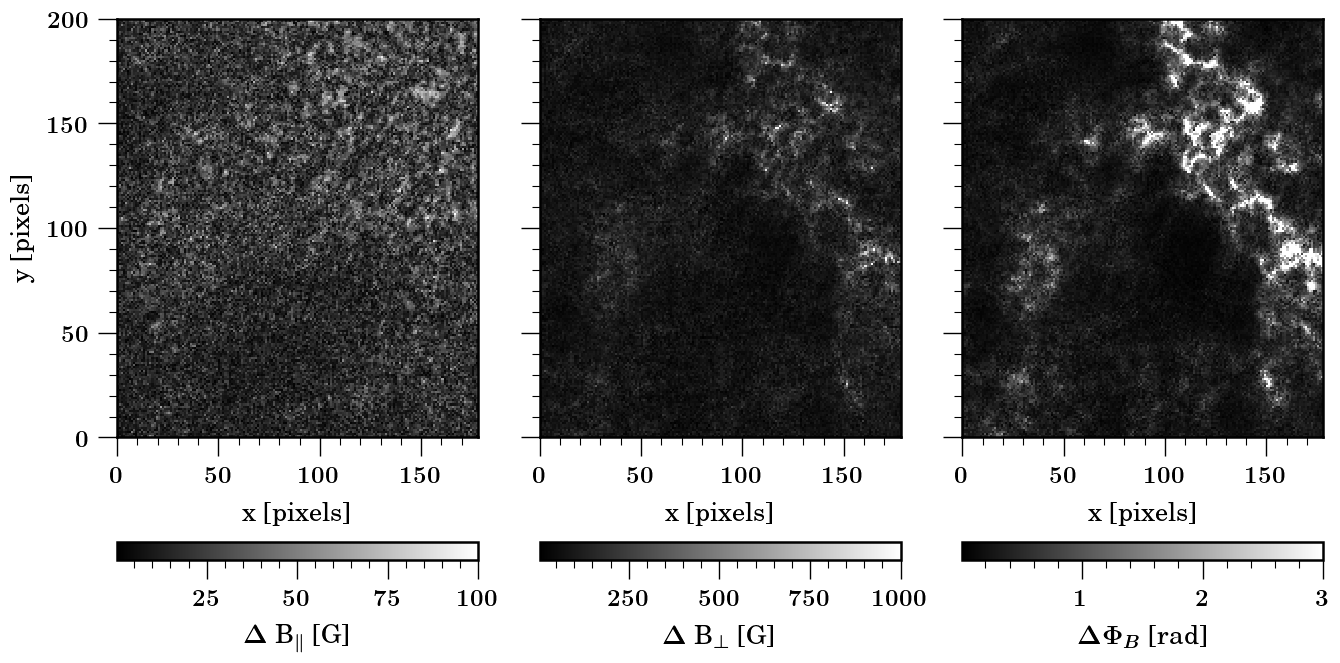

In [17]:
# Compute uncertainties for all parameters:
print("Computing uncertainties using ANALYTICAL method...")
unc_blos_ana, unc_btr_ana, unc_phi_ana = mymodel.estimate_uncertainties(
    out, method='analytical')

plt.close("all");
extent = np.float64((0,nx,0,ny))
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(9*1.5,4.5*1.5))
im0 = ax[0].imshow(unc_blos_ana, extent=extent, aspect='auto', cmap='gray', vmax=1e2)
im1 = ax[1].imshow(unc_btr_ana, extent=extent, aspect='auto', cmap='gray', vmax=1e3)
im2 = ax[2].imshow(unc_phi_ana, extent=extent, aspect='auto', cmap='gray', vmax=3)


names = [r'$\Delta$ B$_\parallel$', r'$\Delta$ B$_\bot$', r'$\Delta \Phi_B$']
f.colorbar(im0, ax=ax[0], orientation='horizontal', label=names[0]+' [G]', pad=0.17)
f.colorbar(im1, ax=ax[1], orientation='horizontal', label=names[1]+' [G]', pad=0.17)
f.colorbar(im2, ax=ax[2], orientation='horizontal', label=names[2]+' [rad]', pad=0.17)


for ii in range(1,3):
    ax[ii].set_yticklabels([])
for ii in range(3):
    ax[ii].set_xlabel('x [pixels]')
    ax[ii].minorticks_on()
    ax[ii].locator_params(axis='x', nbins=5)
    ax[ii].locator_params(axis='y', nbins=5)
ax[0].set_ylabel('y [pixels]')
f.set_tight_layout(True)


for cbar in f.get_axes():
    cbar.minorticks_on()

## $\chi^2$ map and pixel comparison

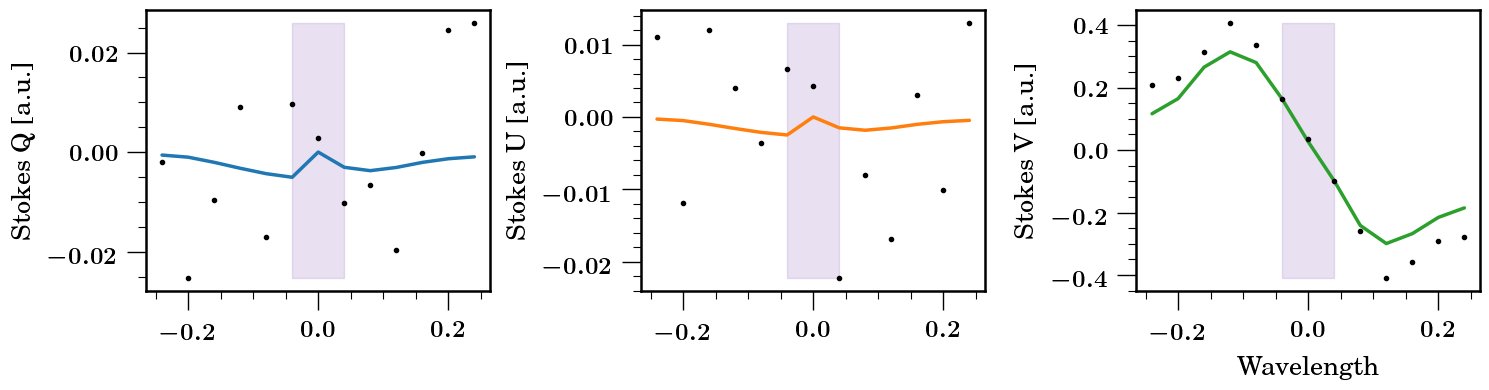

In [ ]:
# Pixel comparison:
stokesQ, stokesU, stokesV = mymodel.forward(out)

stokesQ = utils.torch2plot(stokesQ, mymodel)
stokesU = utils.torch2plot(stokesU, mymodel)
stokesV = utils.torch2plot(stokesV, mymodel)

# Plotting the Stokes parameters for a pixel:
x, y = 150, 150

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10*1.5,4))
ax = ax.flatten()
ax[0].plot(mymodel.wl, stokesQ[0, x, y, :], label='Stokes Q', color='C0')
ax[0].plot(mymodel.wl, img[x, y, 1,:], 'k.',label='Stokes Q')

ax[1].plot(mymodel.wl, stokesU[0, x, y, :], label='Stokes U', color='C1')
ax[1].plot(mymodel.wl, img[x, y, 2,:], 'k.',label='Stokes U')

ax[2].plot(mymodel.wl, stokesV[0, x, y, :], label='Stokes V', color='C2')
ax[2].plot(mymodel.wl, img[y, x, 3,:], 'k.',label='Stokes V')

ax[2].set_xlabel(r"Wavelength")
ax[0].set_ylabel('Stokes Q [a.u.]')
ax[1].set_ylabel('Stokes U [a.u.]')
ax[2].set_ylabel('Stokes V [a.u.]')

# Vertical band with the wavelength used as mask:
for ii in range(3):
    ax[ii].fill_betweenx(
        (img[y, x, ii+1, :].min(), img[y, x, ii+1, :].max()),
        mymodel.wl[mask_index[0]],
        mymodel.wl[mask_index[-1]],
        color='C4',
        alpha=0.2,
        label='Mask used for the estimation',
    )

plt.tight_layout()


Estimated sigma: 0.020288762


Text(0.5, 0, 'x [pixels]')

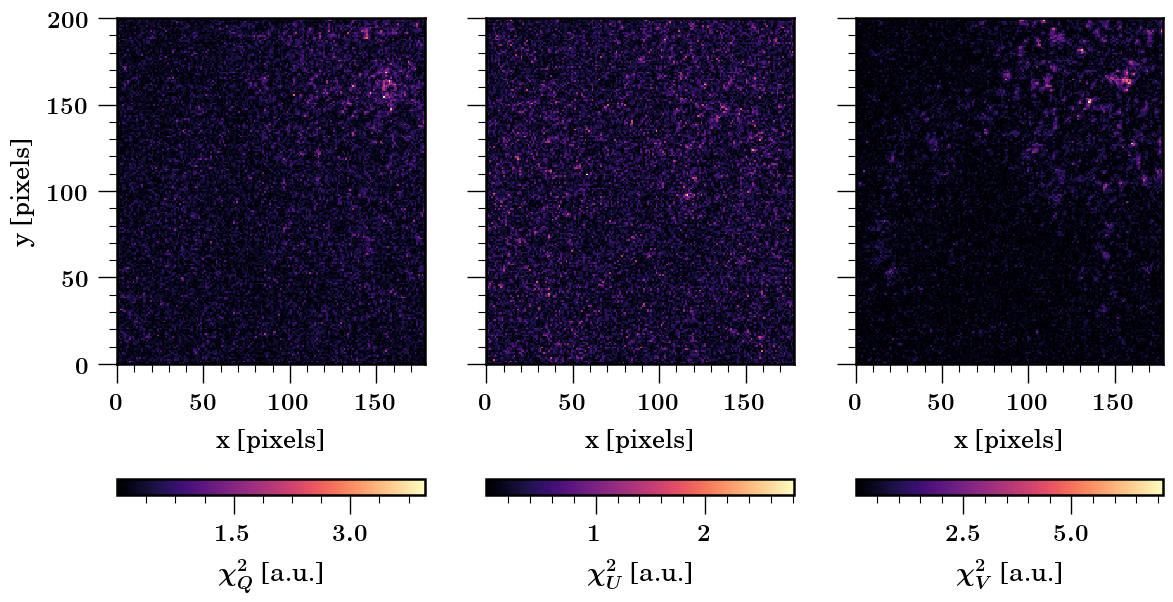

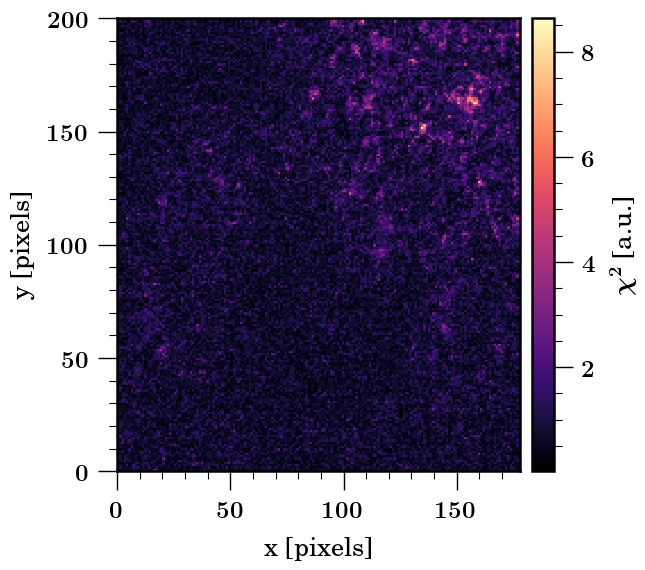

In [ ]:
# Estimated sigma:
sigma = np.std(stokesQ[0, ...] - img[:, :, 1,:])
print("Estimated sigma:", sigma)

# Chi2 maps:
chi2_map_Q = np.mean( (stokesQ[0, ...][..., mymodel.mask] - img[:, :, 1, mymodel.mask])**2 ,axis=2)/ (sigma**2)
chi2_map_U = np.mean( (stokesU[0, ...][..., mymodel.mask] - img[:, :, 2, mymodel.mask])**2 ,axis=2)/ (sigma**2)
chi2_map_V = np.mean( (stokesV[0, ...][..., mymodel.mask] - img[:, :, 3, mymodel.mask])**2 ,axis=2)/ (sigma**2)
chi2_map = chi2_map_Q + chi2_map_U + chi2_map_V


f, ax = plt.subplots(nrows=1, ncols=3, figsize=(9*1.5,7), sharex=True, sharey=True)
ax = ax.flatten()
im0 = ax[0].imshow(chi2_map_Q, cmap='magma', interpolation='nearest', extent=extent)
im1 = ax[1].imshow(chi2_map_U, cmap='magma', interpolation='nearest', extent=extent)
im2 = ax[2].imshow(chi2_map_V, cmap='magma', interpolation='nearest', extent=extent)
names = [r'$\chi^2_Q$', r'$\chi^2_U$', r'$\chi^2_V$']
utils.add_colorbar(im0, ax=ax[0], label=names[0]+' [a.u.]',orientation='horizontal',aspect=0.05, pad_fraction=7.5, nbins=3)
utils.add_colorbar(im1, ax=ax[1], label=names[1]+' [a.u.]',orientation='horizontal',aspect=0.05, pad_fraction=7.5, nbins=3)
utils.add_colorbar(im2, ax=ax[2], label=names[2]+' [a.u.]',orientation='horizontal',aspect=0.05, pad_fraction=7.5, nbins=3)
for ii in range(3):
    ax[ii].set_xlabel('x [pixels]')
    ax[ii].minorticks_on()
    ax[ii].locator_params(axis='x', nbins=5)
    ax[ii].locator_params(axis='y', nbins=5)
ax[0].set_ylabel('y [pixels]')


plt.figure(figsize=(6*1.5,4*1.5))
im = plt.imshow(chi2_map, cmap='magma', interpolation='nearest', extent=extent)
plt.locator_params(axis='both', nbins=5)
utils.add_colorbar(im, label=r"$\chi^2$ [a.u.]")
plt.ylabel('y [pixels]')
plt.xlabel('x [pixels]')
